In [1]:
import sys
import os

In [2]:
sys.path.append('/home/aalvarez/Work/Projects/Elements/5.8/InstallArea/x86_64-fc30-gcc92-dbg/python/')
sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/NNPZ/python/')
os.environ['ELEMENTS_AUX_PATH'] = '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/NNPZ/auxdir/'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from nnpz.photometry import *

In [4]:
sample = Table.read('/home/aalvarez/Work/Data/WillHartley/Sample.fits')

# Let's try computing the first object ourselves

First we need to find the scale factor

In [5]:
sed_name = sample['SED_name'][0]
redshift = sample['z'][0]
i_flux = sample['Flux_i'][0]
i_shift = sample['WL_shift_i'][0]
print(sed_name, redshift, i_flux, i_shift)

CosmosSp/Sc_A_0.sed 0.32931706 1.4120699 22.213533


In [6]:
original_sed = np.genfromtxt('/home/aalvarez/Phosphoros/AuxiliaryData/SEDs/' + sed_name)
sed = original_sed.copy()
sed[:, 0] *= 1 + redshift
sed[:, 1] /= (1 + redshift)**2

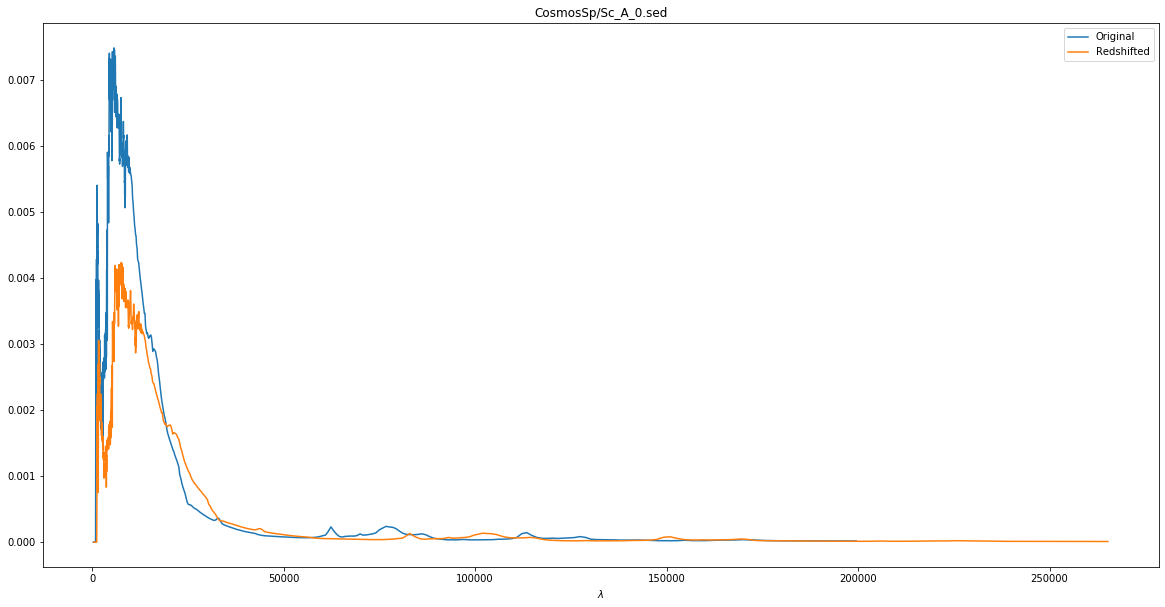

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(original_sed[:, 0], original_sed[:, 1], label='Original')
plt.plot(sed[:, 0], sed[:, 1], label='Redshifted')
plt.xlabel('$\lambda$')
plt.title(sed_name)
plt.legend()
plt.show()

In [8]:
dir_prov = DirectoryFilterProvider('/home/aalvarez/Work/Data/WillHartley/DC3')
shifted_prov = ShiftedFilterProvider(dir_prov, ['i'], [i_shift])

In [9]:
fnuu_prepost = FnuuJyPrePostProcessor()

In [10]:
transmissions = {
    'i': shifted_prov.getFilterTransmission('i'),
    'i_shifted': shifted_prov.getFilterTransmission('i_{}'.format(i_shift)),
}

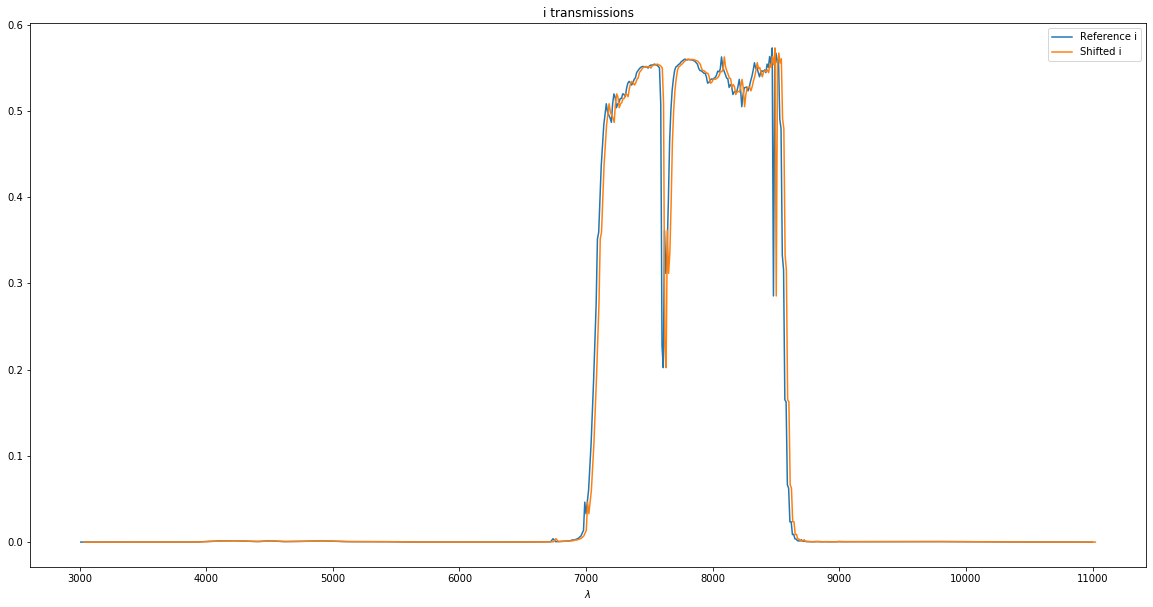

In [11]:
plt.figure(figsize=(20,10))
plt.plot(transmissions['i'][:,0], transmissions['i'][:,1], label='Reference i')
plt.plot(transmissions['i_shifted'][:,0], transmissions['i_shifted'][:,1], label='Shifted i')
plt.xlabel('$\lambda$')
plt.title('i transmissions')
plt.legend()
plt.show()

In [12]:
calculator = PhotometryCalculator(transmissions, fnuu_prepost)

In [13]:
recomputed_i_shifted = calculator.compute(sed)['i_shifted']
print(recomputed_i_shifted)

8090747691237642.0


In [14]:
scale=i_flux/recomputed_i_shifted
print(scale, recomputed_i_shifted*scale, i_flux)

1.7452897687743298e-16 1.4120699167251587 1.4120699


# Verify with other filters

In [15]:
other_filters = ['u', 'g', 'r', 'z', 'vis', 'Y', 'J', 'H']
other_fluxes = []
other_errors = []
other_shifts = []
for f in other_filters:
    other_fluxes.append(sample[f'Flux_{f}'][0])
    other_errors.append(sample[f'Fluxerr_{f}'][0])
    other_shifts.append(sample[f'WL_shift_{f}'][0])

other_shifted_prov = ShiftedFilterProvider(dir_prov, other_filters, other_shifts)

other_transmissions = dict()
for f, s in zip(other_filters, other_shifts):
    other_transmissions[f] = other_shifted_prov.getFilterTransmission(f'{f}_{s}')

In [16]:
other_calculator = PhotometryCalculator(other_transmissions, fnuu_prepost)

In [17]:
recomputed_other = other_calculator.compute(sed)

In [18]:
for f, flx, flxerr in zip(other_filters, other_fluxes, other_errors):
    print('{}\t{:.5f}\t{:.5f}\t{:.5f}\t{}'.format(f, flx, flxerr, recomputed_other[f'{f}']*scale, flx+flxerr>recomputed_other[f'{f}']*scale>flx-flxerr))

u	-0.10254	0.14454	0.10426	False
g	0.29499	0.03631	0.29349	True
r	0.99204	0.05754	0.91759	False
z	1.83403	0.14454	1.76377	True
vis	1.03534	0.05754	1.12328	False
Y	2.03555	0.22909	2.30986	False
J	3.42065	0.22909	3.22241	True
H	3.91902	0.36308	3.74019	True
